In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
!pip install -q scipy wandb


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
# from peft import LoraConfig, PeftModel
# from trl import SFTTrainer

In [3]:
model_name = "NousResearch/Llama-2-7b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json: 100%|██████████| 746/746 [00:00<00:00, 1.80MB/s]
tokenizer.model: 100%|██████████| 500k/500k [00:00<00:00, 17.4MB/s]
tokenizer.json: 100%|██████████| 1.84M/1.84M [00:00<00:00, 33.4MB/s]
added_tokens.json: 100%|██████████| 21.0/21.0 [00:00<00:00, 120kB/s]
config.json: 100%|██████████| 583/583 [00:00<00:00, 1.88MB/s]
model.safetensors.index.json: 100%|██████████| 26.8k/26.8k [00:00<00:00, 46.8MB/s]
model-00001-of-00002.safetensors: 100%|██████████| 9.98G/9.98G [00:39<00:00, 254MB/s]
model-00002-of-00002.safetensors: 100%|██████████| 3.50G/3.50G [00:15<00:00, 231MB/s]
generation_config.json: 100%|██████████| 179/179 [00:00<00:00, 648kB/s]
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the ge

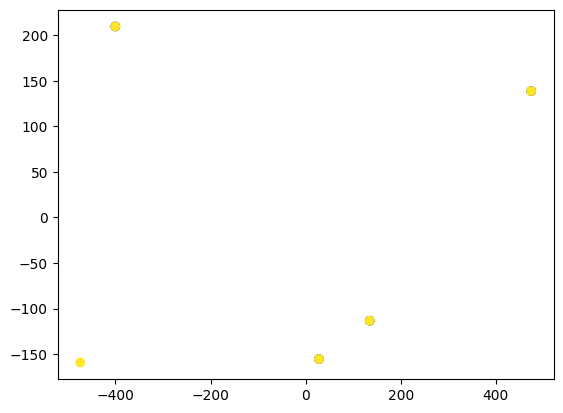

: 

In [9]:
import numpy as np

string_1 = "I like you"
string_2 = "I like you more"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

with torch.no_grad():
    tokens_1 = tokenizer(string_1, return_tensors="pt").input_ids.to(device)
    tokens_2 = tokenizer(string_2, return_tensors="pt").input_ids.to(device)

    output_1 = model(input_ids=tokens_1, return_dict=True)
    output_2 = model(input_ids=tokens_2, return_dict=True)
    logits_1 = output_1.logits[0].detach().cpu().numpy()
    logits_2 = output_2.logits[0].detach().cpu().numpy()

logits = np.concatenate([logits_1, logits_2])
labels = np.concatenate([np.zeros(len(logits_1)), np.ones(len(logits_2))])
from sklearn.decomposition import PCA

logits_2d = PCA(n_components=2).fit_transform(logits)
import matplotlib.pyplot as plt

plt.scatter(logits_2d[:, 0], logits_2d[:, 1], c=labels)

In [4]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# Fine-tuned model name
new_model = "llama-2-7b-first-person"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 16

# Alpha parameter for LoRA scaling
lora_alpha = 32

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "/workspace/results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule (constant a bit better than cosine)
lr_scheduler_type = "constant"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 500

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = 2048

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [5]:
from get_data import get_dataset

dataset = get_dataset(conv_size=20)

In [6]:

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Your GPU supports bfloat16: accelerate training with bf16=True


Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.94s/it]


In [7]:
lora_folder = "/workspace/results/checkpoint-3500/"

new_model = PeftModel.from_pretrained(
    model,
    lora_folder)

In [13]:
tokenizer.encode("\n\n\n")

[1, 29871, 13, 13, 13]

In [36]:
from transformers import StoppingCriteria, StoppingCriteriaList

conversation = """
Dennis: So what's up?
I: nothing, really.
Dennis: Oh come on, there's gotta be something.
"""

format_prompt = """
<s>[INST] <<SYS>>
You are a human in a movie, and other people are talking to you! Respond to them.
<</SYS>>

Conversations so far:
{input}
You respond with:
[/INST]
""".strip()

class TokenStoppingCriteria(StoppingCriteria):
    def __call__(self, input_ids, scores, **kwargs):
        string = tokenizer.decode(input_ids[0])
        if string.endswith("[/INST]\n"):
            return False
        if string.endswith("\n"):
            return True
        return False

stopping_criteria = StoppingCriteriaList(
    [TokenStoppingCriteria()]
)

print(conversation)

while True:
    input_text = format_prompt.format(input=conversation)
    print("Input: " + input_text + "\n")
    input_tokens = tokenizer(input_text, return_tensors="pt").input_ids

    results = model.generate(
        input_tokens,
        stopping_criteria=stopping_criteria,
        max_length=200,
    )

    result_string = tokenizer.decode(results[0])
    response = result_string.split("\n")[-2]
    print("Model: " + response + "\n")
    conversation += response + "\n"

    user_input = input("Dennis: ").strip()
    conversation += "Dennis: " + user_input + "\n"

    print(conversation + "\n\n\n")


Dennis: So what's up?
I: nothing, really.
Dennis: Oh come on, there's gotta be something.

Input: <s>[INST] <<SYS>>
You are a human in a movie, and other people are talking to you! Respond to them.
<</SYS>>

Conversations so far:

Dennis: So what's up?
I: nothing, really.
Dennis: Oh come on, there's gotta be something.

You respond with:
[/INST]



/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1468: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


Model: I: I'm fine.


Dennis: So what's up?
I: nothing, really.
Dennis: Oh come on, there's gotta be something.
I: I'm fine.
Dennis: you sure?




Input: <s>[INST] <<SYS>>
You are a human in a movie, and other people are talking to you! Respond to them.
<</SYS>>

Conversations so far:

Dennis: So what's up?
I: nothing, really.
Dennis: Oh come on, there's gotta be something.
I: I'm fine.
Dennis: you sure?

You respond with:
[/INST]

Model: I: I'm fine.


Dennis: So what's up?
I: nothing, really.
Dennis: Oh come on, there's gotta be something.
I: I'm fine.
Dennis: you sure?
I: I'm fine.
Dennis: 




Input: <s>[INST] <<SYS>>
You are a human in a movie, and other people are talking to you! Respond to them.
<</SYS>>

Conversations so far:

Dennis: So what's up?
I: nothing, really.
Dennis: Oh come on, there's gotta be something.
I: I'm fine.
Dennis: you sure?
I: I'm fine.
Dennis: 

You respond with:
[/INST]

Model: I: I'm fine.


Dennis: So what's up?
I: nothing, really.
Dennis: Oh come on, 

KeyboardInterrupt: Interrupted by user